In [45]:
from collections import defaultdict
import glob
from datetime import datetime


import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

import pandas as pd
import seaborn


In [30]:
idir = '/data1/antonk/sitac_validation'

sources = ['NIC', 'DMI']
frmts = ['%y%m%d.npz', '%Y%m%d.npz']
var_names = ['accuracy', 'macro_precision', 'macro_recall', 'macro_f1_score']

ice_names = ['water', 'young_ice', 'first_year_ice', 'multi_year_ice']
ice_var_names = ['precision', 'recall', 'fscore', 'total_man', 'total_aut']

values = defaultdict(list)
dates = []
confmatrs = defaultdict(list)
for src, frmt in zip(sources, frmts):
    ifiles = sorted(glob.glob(f'{idir}/{src}/*npz'))
    
    for ifile in ifiles:
        d = dict(np.load(ifile, allow_pickle=True))
        if 'none' in d:
            continue
        dates.append(datetime.strptime(ifile.split('_')[-1], frmt))
        values['source'].append(src)
        for var_name in var_names:
            values[var_name].append(d[var_name].item())
        for ice_var_name in ice_var_names:
            ice_values = d[ice_var_name]
            if len(ice_values) < 4:
                ice_values = [np.nan, np.nan, np.nan, np.nan]
            for ice_name, ice_value in zip(ice_names, ice_values):
                var_name = f'{ice_name}_{ice_var_name}'
                values[var_name].append(ice_value)
        confmatrs[src].append(d['matrix'])


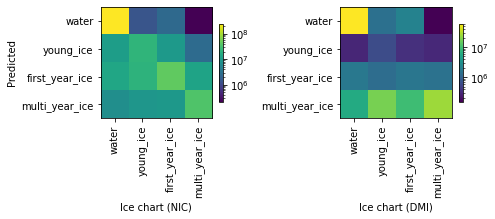

In [56]:
fig, axs = plt.subplots(1,2,figsize=(7,3))
for i, src in enumerate(sources):
    m = np.dstack([m for m in confmatrs[src] if m.shape == (4,4)])
    plt.colorbar(axs[i].imshow(m.sum(axis=2), norm=LogNorm()), ax=axs[i], shrink=0.7)
    axs[i].set_xticks([0,1,2,3], ice_names, rotation=90)
    axs[i].set_yticks([0,1,2,3], ice_names)
    axs[i].set_xlabel(f'Ice chart ({src})')
axs[0].set_ylabel('Predicted')
plt.tight_layout()
plt.savefig(f'{idir}/confusion_matrix.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [34]:
df = pd.DataFrame(values, index=dates)
df['month'] = df.index.strftime('%b')
show_names = df.columns.drop(['source', 'month'])
show_names

Index(['accuracy', 'macro_precision', 'macro_recall', 'macro_f1_score',
       'water_precision', 'young_ice_precision', 'first_year_ice_precision',
       'multi_year_ice_precision', 'water_recall', 'young_ice_recall',
       'first_year_ice_recall', 'multi_year_ice_recall', 'water_fscore',
       'young_ice_fscore', 'first_year_ice_fscore', 'multi_year_ice_fscore',
       'water_total_man', 'young_ice_total_man', 'first_year_ice_total_man',
       'multi_year_ice_total_man', 'water_total_aut', 'young_ice_total_aut',
       'first_year_ice_total_aut', 'multi_year_ice_total_aut'],
      dtype='object')

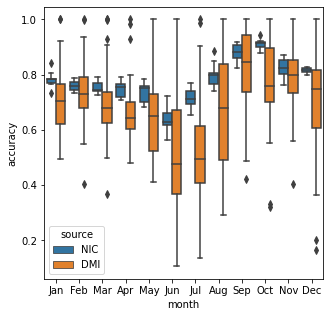

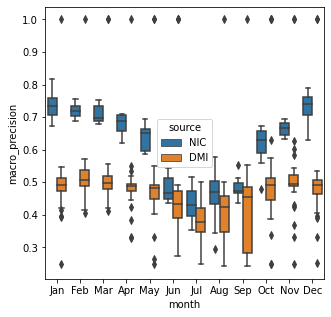

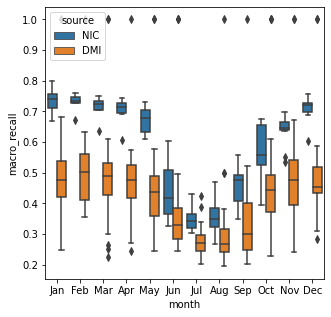

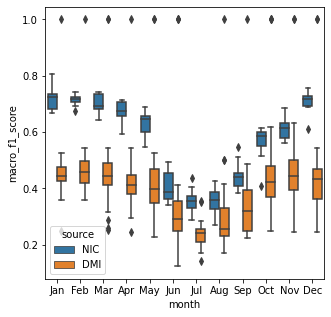

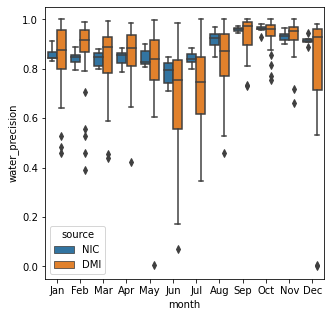

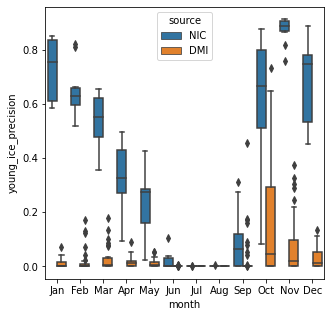

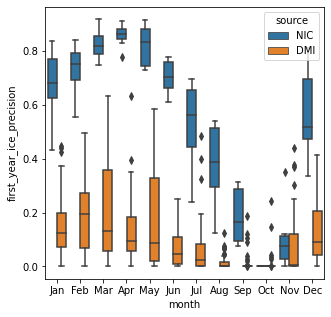

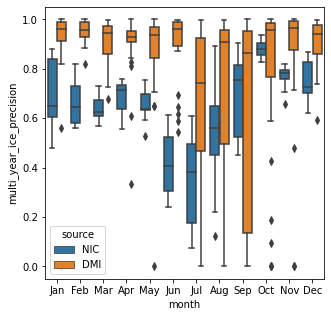

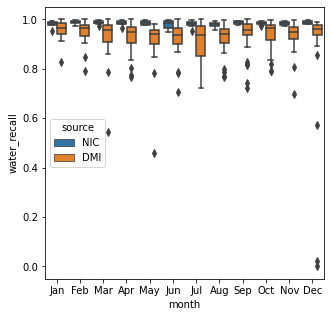

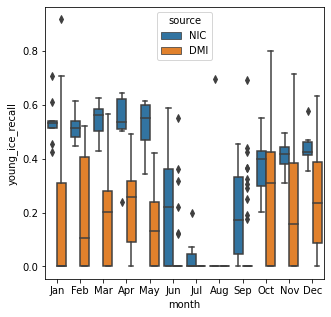

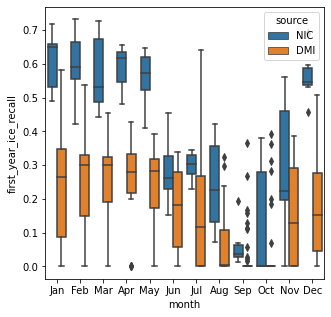

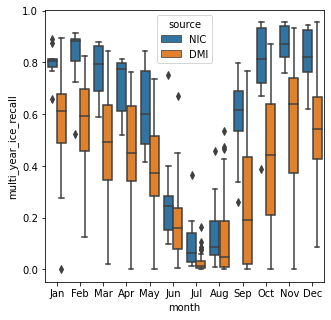

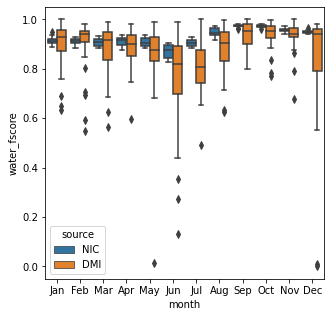

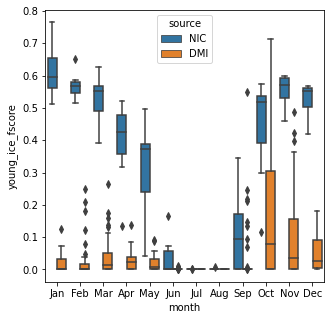

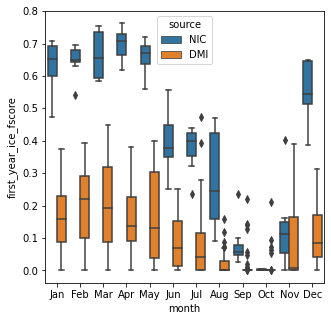

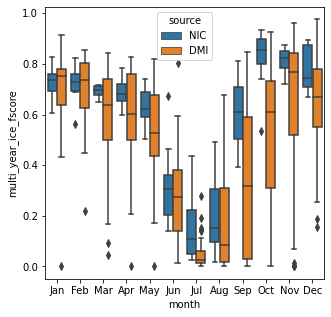

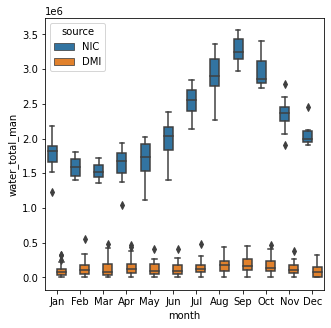

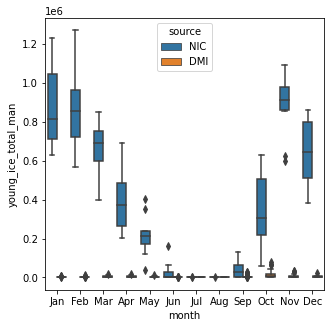

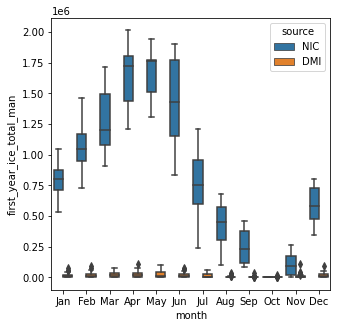

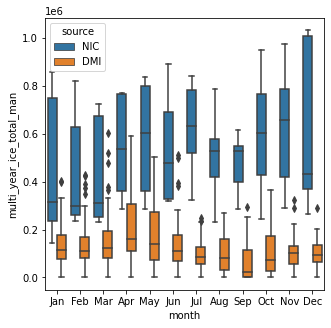

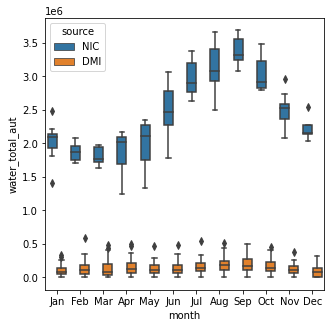

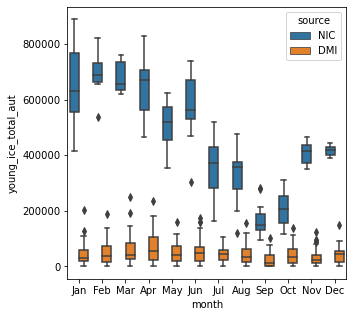

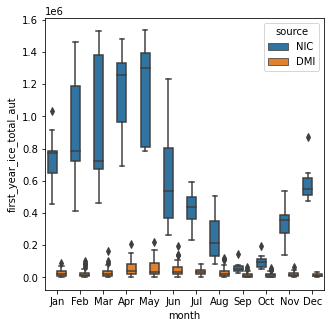

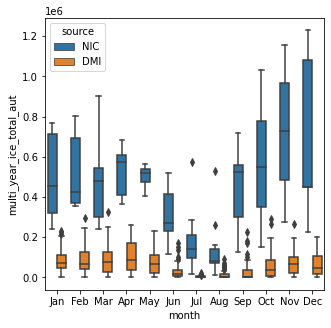

In [57]:
for var_name in show_names:
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    seaborn.boxplot(x='month', y=var_name, data=df, hue='source')
    plt.savefig(f'{idir}/{var_name}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    